In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/axial/t1c", t2f_dir="PED_Sliced/axial/t2f", seg_dir="PED_Sliced/axial/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4324
136
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])


In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi


class AttnUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttnUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim = 1)
        c6 = self.conv6(merge6)

        up7 = self.up7(c6)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim = 1)
        c7 = self.conv7(merge7)

        up8 = self.up8(c7)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim = 1)
        c8 = self.conv8(merge8)

        up9 = self.up9(c8)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [7]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#         # Downsample path
#         self.conv1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.conv2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.conv3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.conv4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)

#         # Bottom
#         self.conv5 = self.double_conv(512, 1024)

#         # Upsample path
#         self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
#         self.conv6 = self.double_conv(1024, 512)
#         self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
#         self.conv7 = self.double_conv(512, 256)
#         self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
#         self.conv8 = self.double_conv(256, 128)
#         self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
#         self.conv9 = self.double_conv(128, 64)

#         # Output
#         self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True)
#         )

#     def forward(self, x):
#         # Downsample path
#         c1 = self.conv1(x)
#         p1 = self.pool1(c1)
#         c2 = self.conv2(p1)
#         p2 = self.pool2(c2)
#         c3 = self.conv3(p2)
#         p3 = self.pool3(c3)
#         c4 = self.conv4(p3)
#         p4 = self.pool4(c4)

#         # Bottom
#         c5 = self.conv5(p4)

#         # Upsample path
#         # up6 = self.up6(c5)
#         up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
#         merge6 = torch.cat([up6, c4], dim = 1)
#         c6 = self.conv6(merge6)

#         up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
#         merge7 = torch.cat([up7, c3], dim = 1)
#         c7 = self.conv7(merge7)

#         up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
#         merge8 = torch.cat([up8, c2], dim = 1)
#         c8 = self.conv8(merge8)

#         up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
#         merge9 = torch.cat([up9, c1], dim = 1)
#         c9 = self.conv9(merge9)

#         # Output
#         out = self.conv10(c9)
#         return out
    
#     def predict(self, x):
#         out = self.forward(x)
#         _, preds = torch.max(out, 1)
#         return preds


In [8]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [9]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [10]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "Attnunet_PED_axial_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = AttnUNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = AttnUNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "Attnunet_PED_axial_comb.pth")

    
    return model


In [11]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


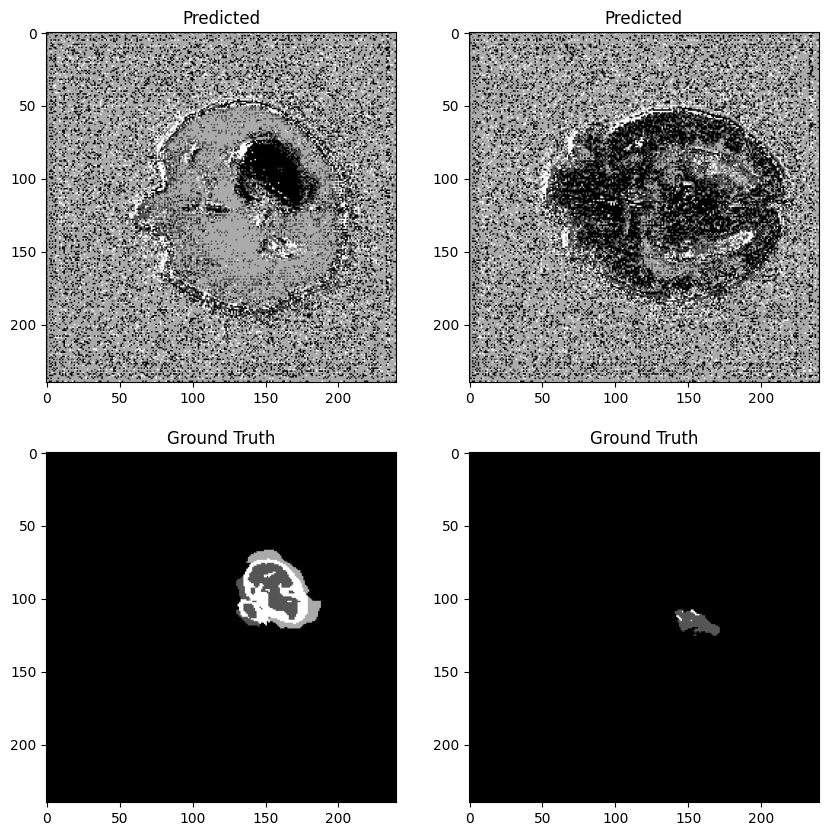

100%|██████████| 136/136 [06:35<00:00,  2.91s/it]



Average Training Loss: 1.168472962344394

Average Training DSC: [0.93620522 0.1427075  0.04233787 0.15997871]
Average Training ASSD: [ 10.16407413 179.12268793 280.49847962  19.18548844]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


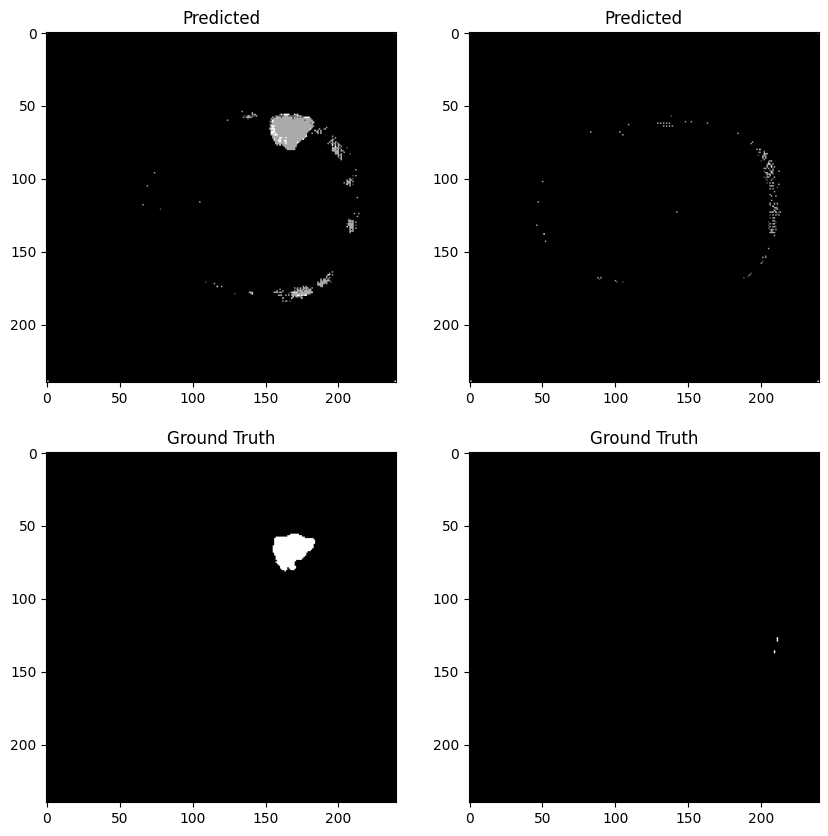

100%|██████████| 34/34 [01:16<00:00,  2.25s/it]


Average Validation Loss: 1.0009366904988009

Average Validation DSC: [0.99414132 0.23938491 0.06670956 0.18237282]
Average Validation ASSD: [  4.73717692 168.10335253 271.27212995  14.69581746]
Epoch 2/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


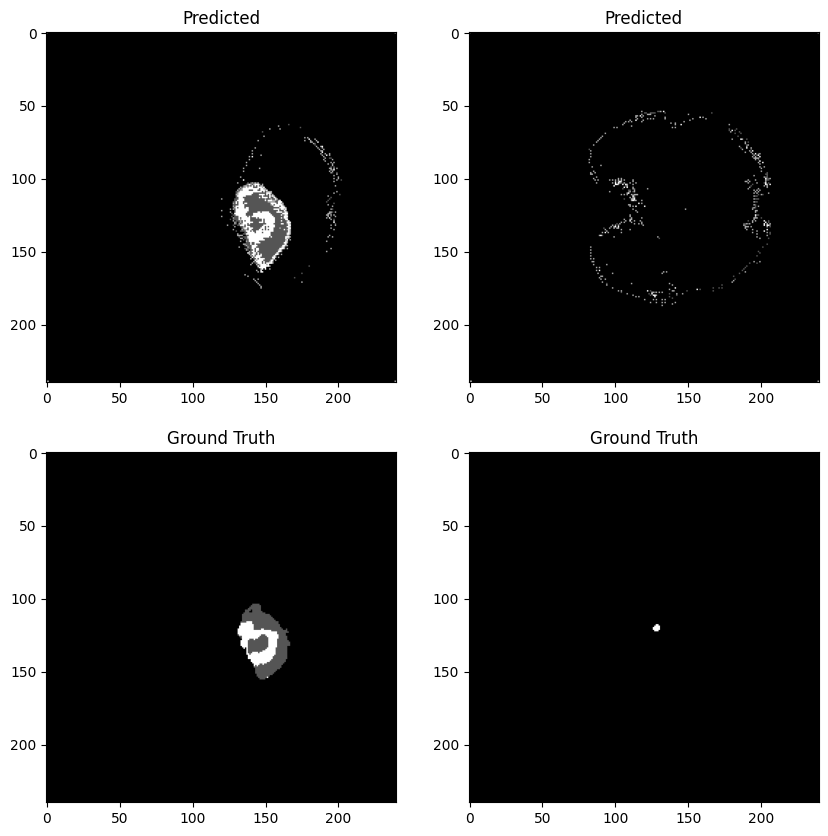

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.9388674896429566

Average Training DSC: [0.99516805 0.25938594 0.05676706 0.23571239]
Average Training ASSD: [  2.50085051 174.2227594  276.76939031  17.04906468]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


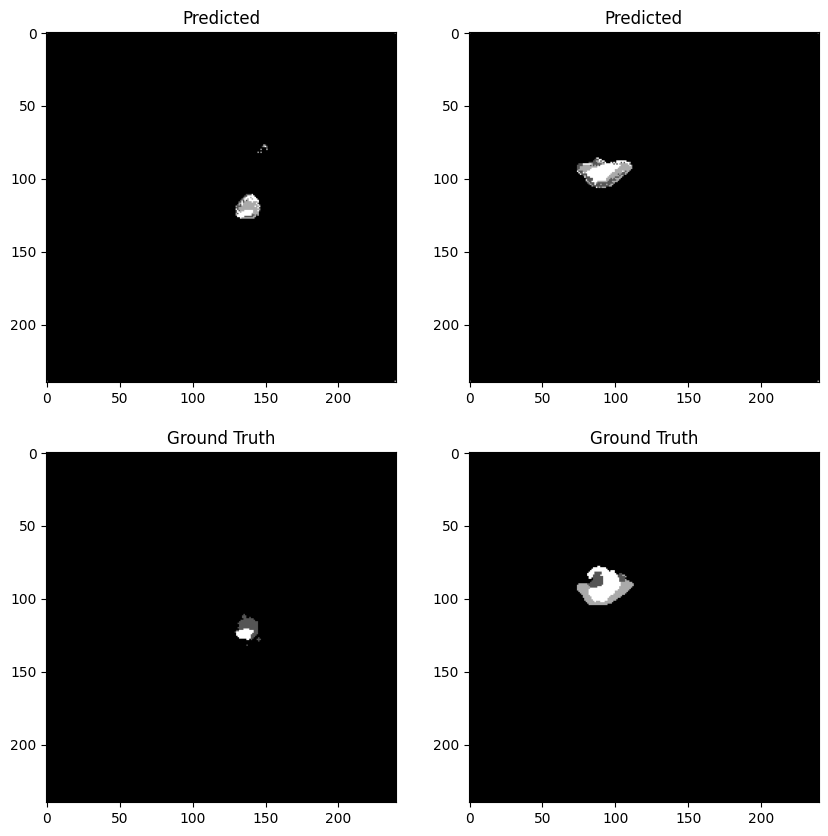

100%|██████████| 34/34 [01:05<00:00,  1.91s/it]


Average Validation Loss: 0.6775318103678086

Average Validation DSC: [0.99679696 0.2845755  0.08362882 0.32971539]
Average Validation ASSD: [  0.75314966 155.04601721 270.50771491  21.5874676 ]
Epoch 3/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


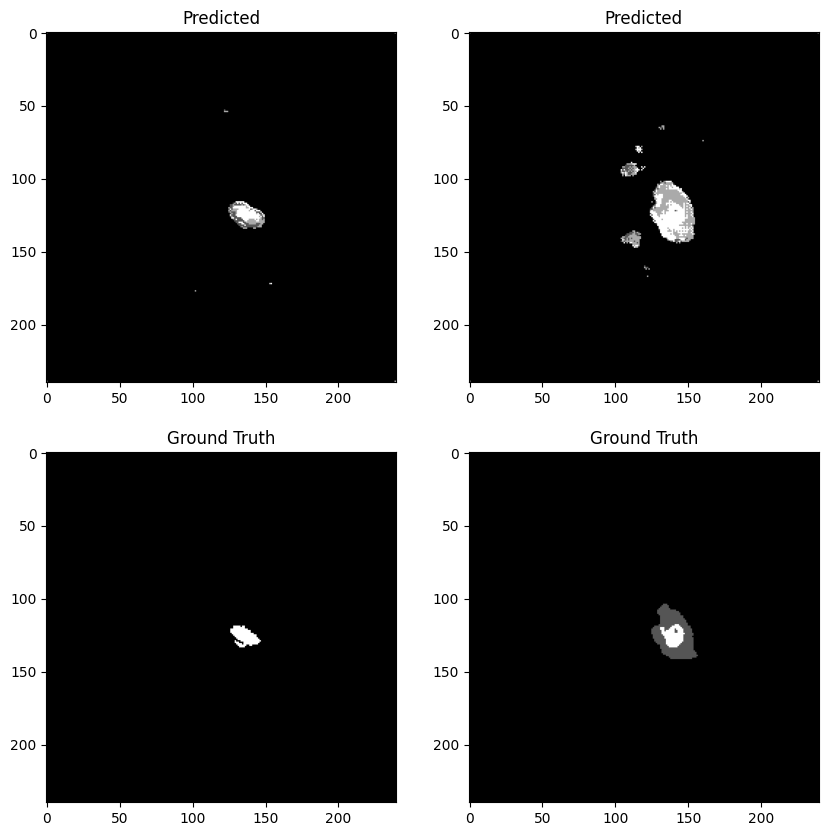

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.733613846494871

Average Training DSC: [0.99701976 0.26515647 0.06698686 0.33714254]
Average Training ASSD: [  0.8756133  171.98990505 276.46696446  24.24470088]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


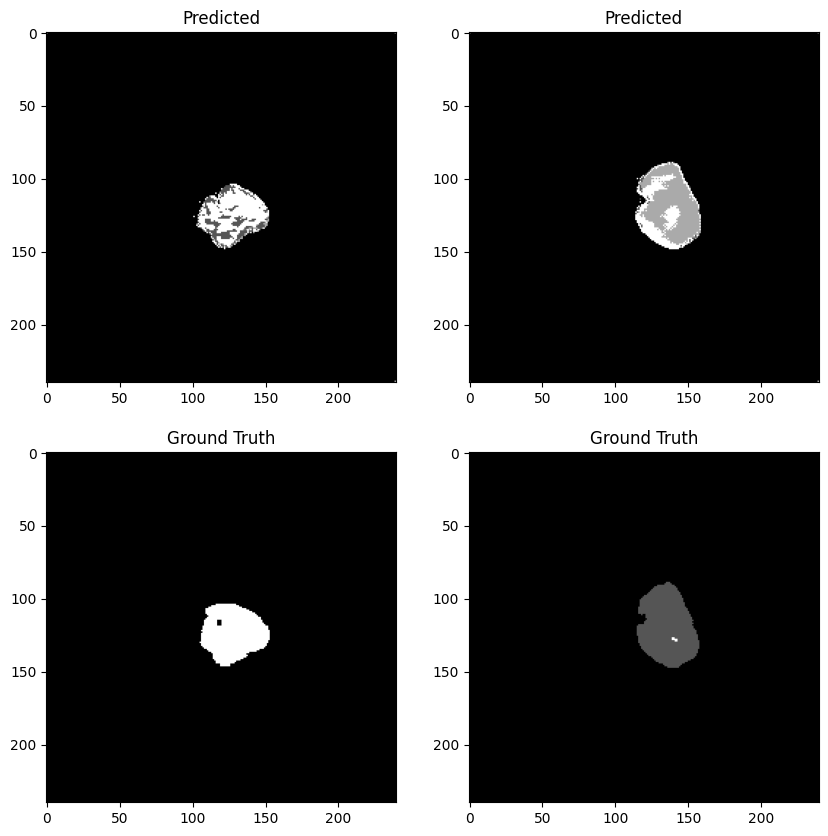

100%|██████████| 34/34 [01:05<00:00,  1.92s/it]


Average Validation Loss: 0.49299154825070324

Average Validation DSC: [0.99695668 0.24046478 0.06724866 0.38463973]
Average Validation ASSD: [  0.9077929  169.4777338  270.98135148  20.03850734]
Epoch 4/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


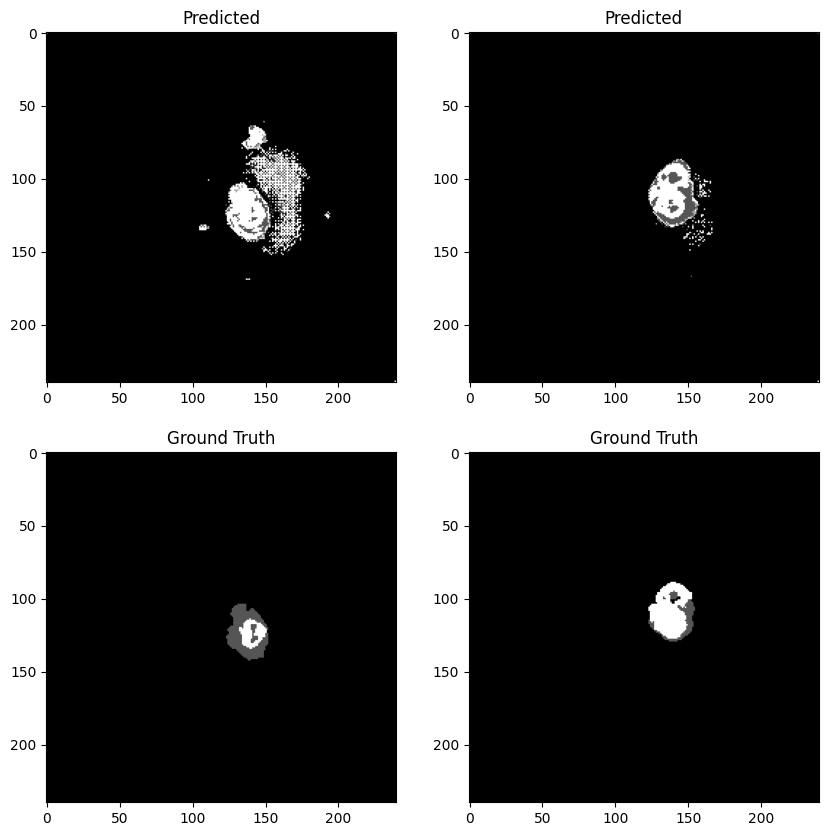

100%|██████████| 136/136 [05:14<00:00,  2.31s/it]



Average Training Loss: 0.5212663609315368

Average Training DSC: [0.9947336  0.24409957 0.07996615 0.37129797]
Average Training ASSD: [  1.2809603  176.76289821 268.11872452  22.02422046]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


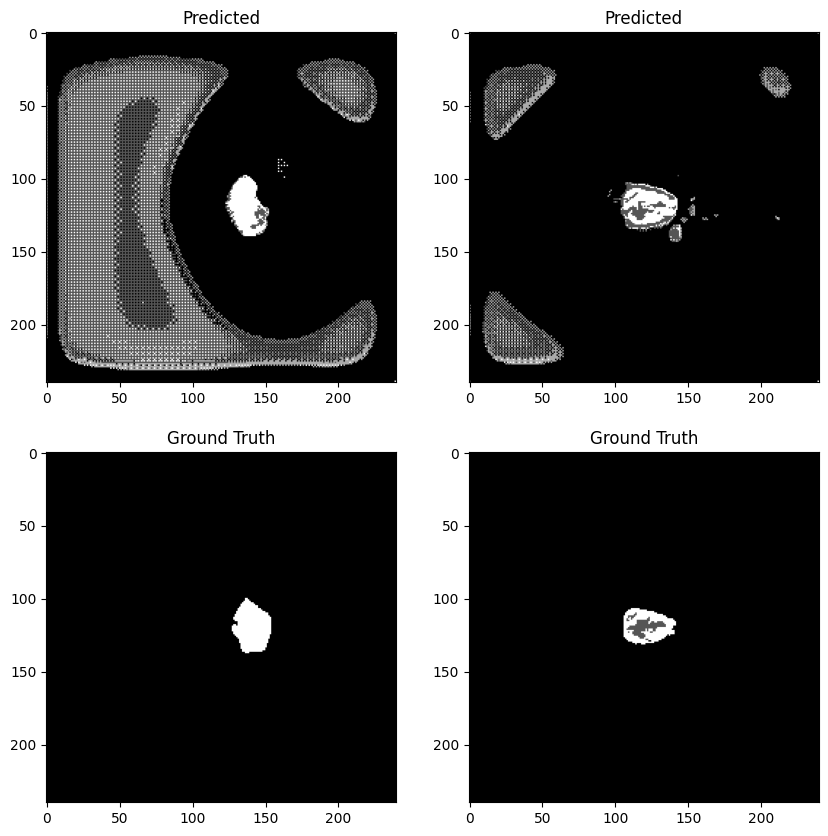

100%|██████████| 34/34 [01:08<00:00,  2.02s/it]


Average Validation Loss: 0.7094813953427708

Average Validation DSC: [0.89674566 0.08622453 0.01021028 0.23547108]
Average Validation ASSD: [  9.83435018 188.65490593 281.46924785  47.11661213]
Epoch 5/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


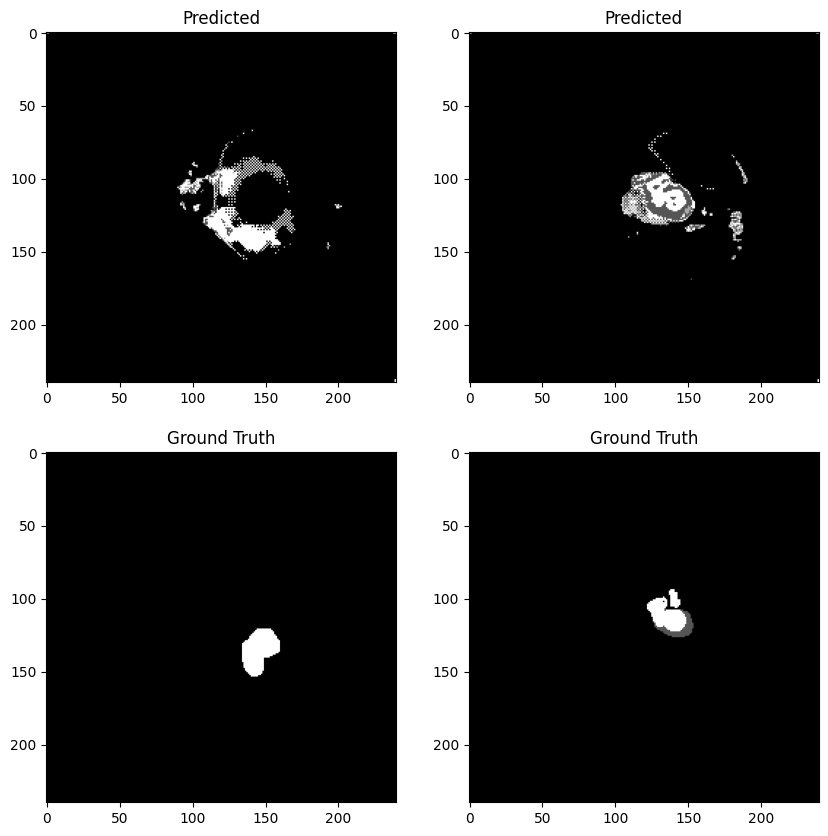

100%|██████████| 136/136 [05:13<00:00,  2.31s/it]



Average Training Loss: 0.38988252663437056

Average Training DSC: [0.996162   0.23820611 0.11113983 0.35507056]
Average Training ASSD: [  1.14776319 178.63374978 250.88851869  23.45191398]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


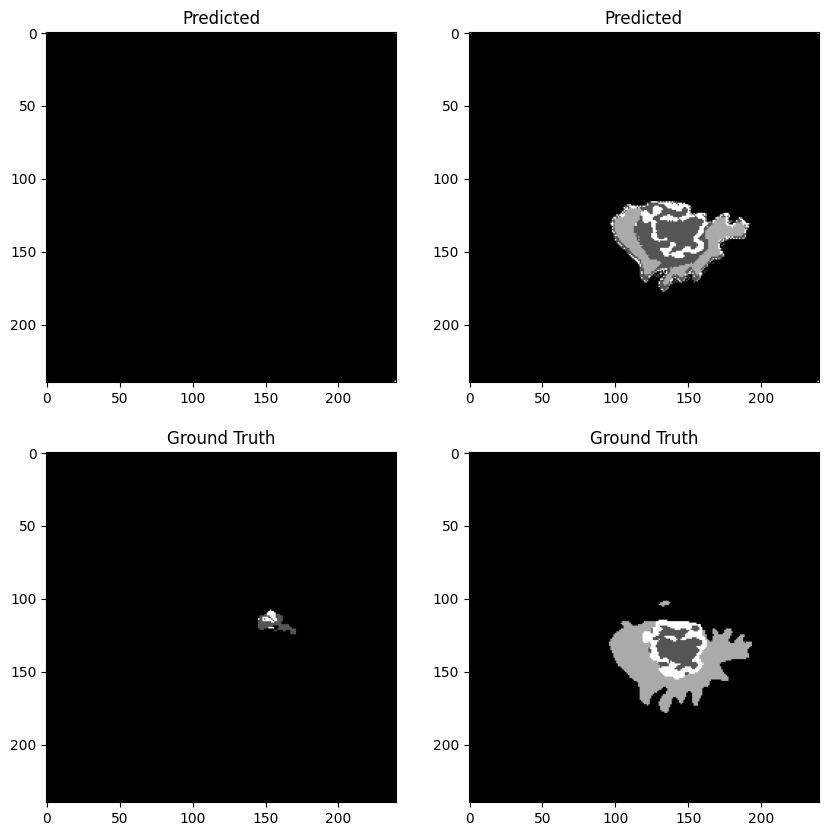

100%|██████████| 34/34 [01:05<00:00,  1.93s/it]


Average Validation Loss: 0.2540743013515192

Average Validation DSC: [0.99737459 0.22929835 0.17196709 0.36603139]
Average Validation ASSD: [  0.85234223 172.36263359 226.85089701  27.31996411]
Epoch 6/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


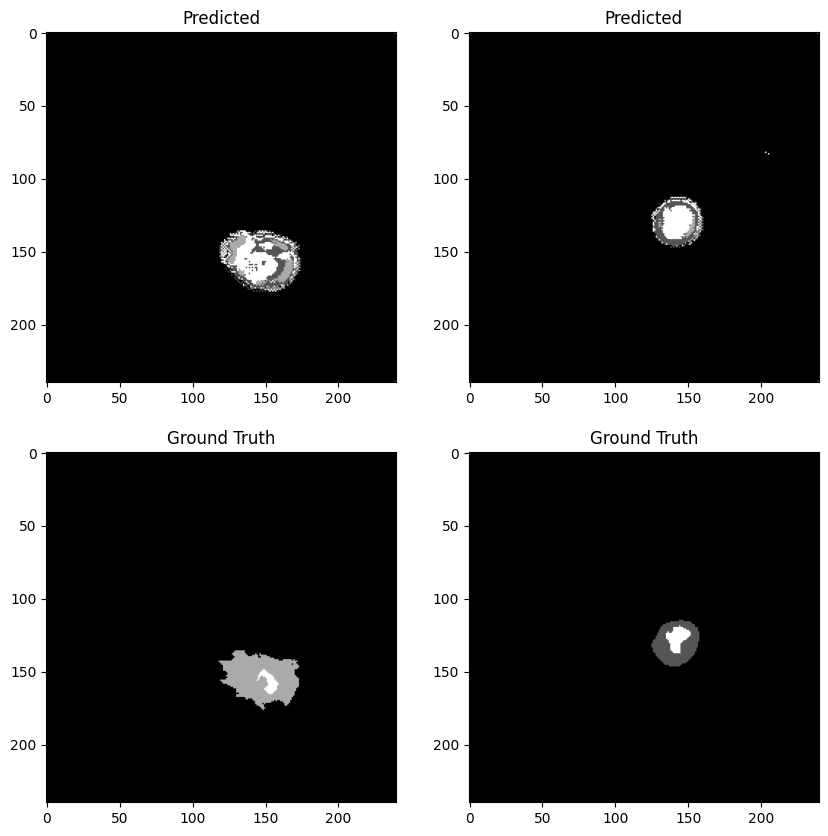

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.26763317569652023

Average Training DSC: [0.99758494 0.23496239 0.18030934 0.40156841]
Average Training ASSD: [  0.71387981 180.31672519 231.06213475  27.6606389 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


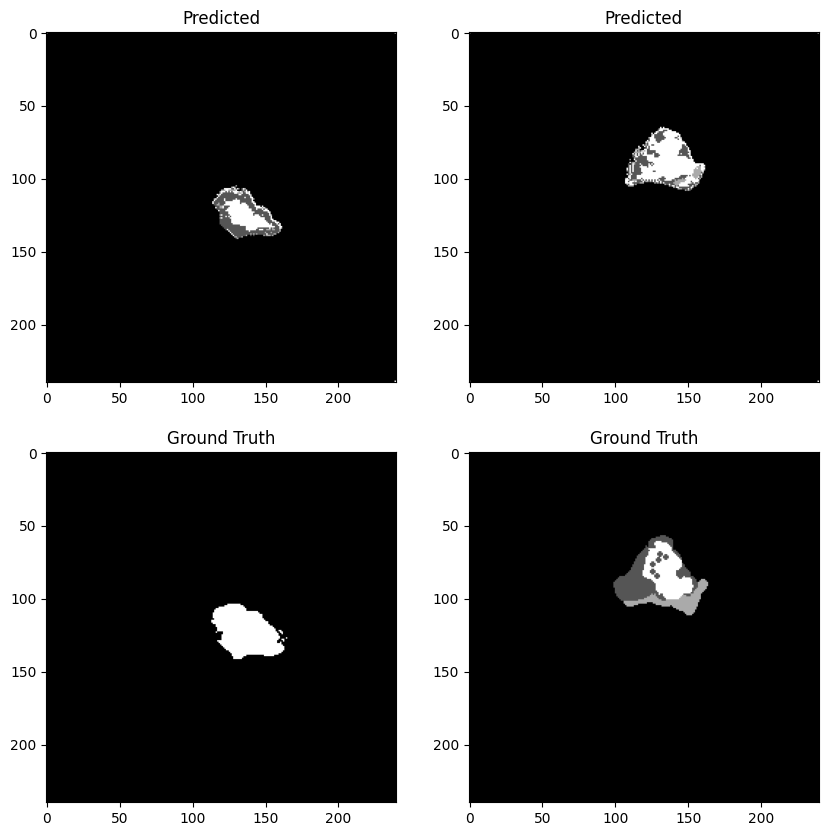

100%|██████████| 34/34 [01:07<00:00,  1.98s/it]


Average Validation Loss: 0.2002811668550267

Average Validation DSC: [0.99785105 0.25335571 0.19445012 0.41195844]
Average Validation ASSD: [  0.54230426 171.18592841 226.75516652  24.99113823]
Epoch 7/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


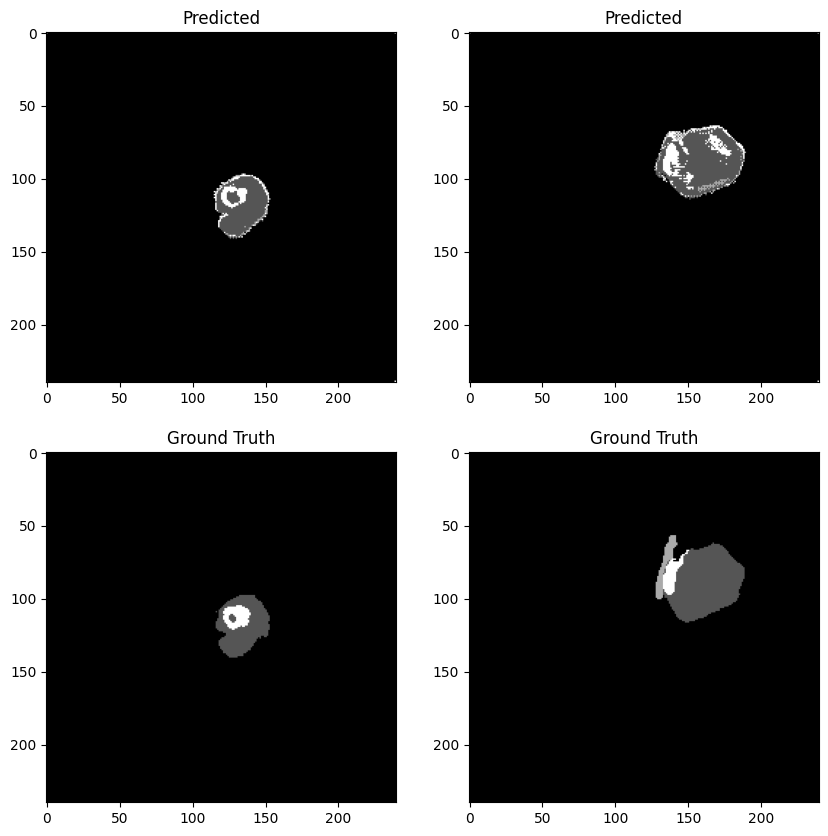

100%|██████████| 136/136 [05:20<00:00,  2.36s/it]



Average Training Loss: 0.1954721839112394

Average Training DSC: [0.99776239 0.26024975 0.19806127 0.42042221]
Average Training ASSD: [  0.61581354 176.52919849 226.603769    26.99803384]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


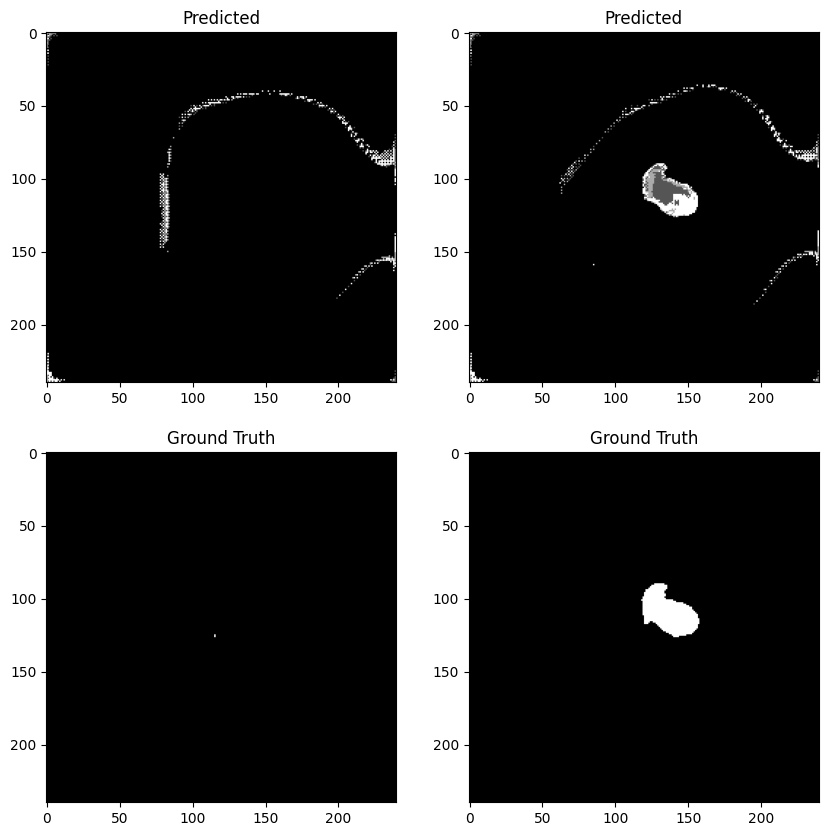

100%|██████████| 34/34 [01:07<00:00,  1.99s/it]


Average Validation Loss: 0.13710679464480457

Average Validation DSC: [0.99100555 0.20156077 0.02852581 0.31551284]
Average Validation ASSD: [  7.31517672 178.59118884 276.90576296  35.33571129]
Epoch 8/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


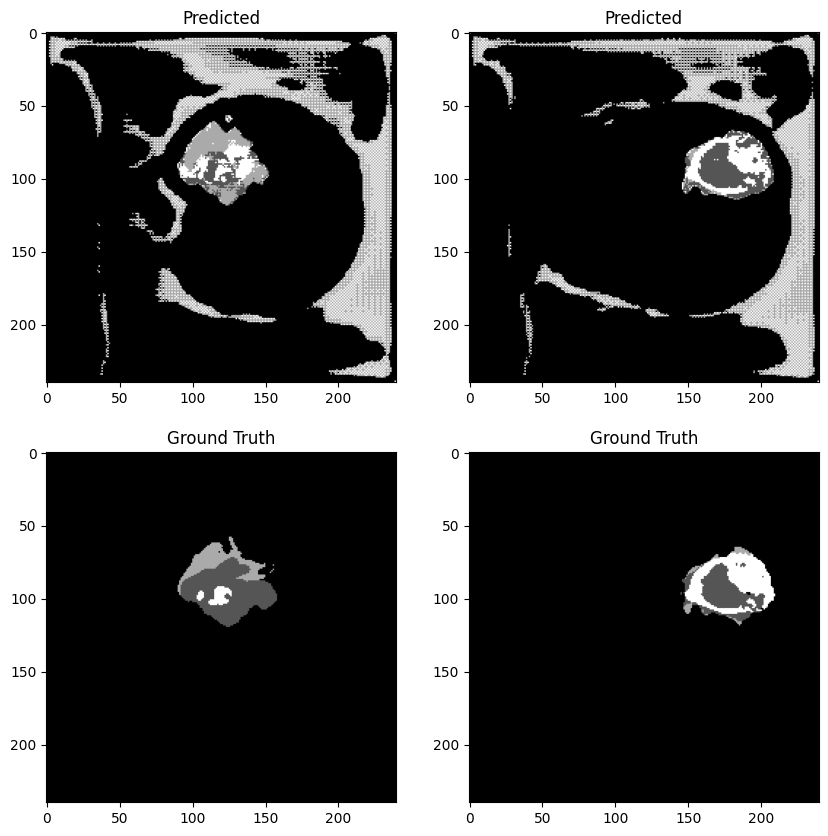

100%|██████████| 136/136 [05:11<00:00,  2.29s/it]



Average Training Loss: 0.1901027674731963

Average Training DSC: [0.99651454 0.32423605 0.11945904 0.361286  ]
Average Training ASSD: [  0.83646475 146.42392928 248.22535733  29.29560141]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


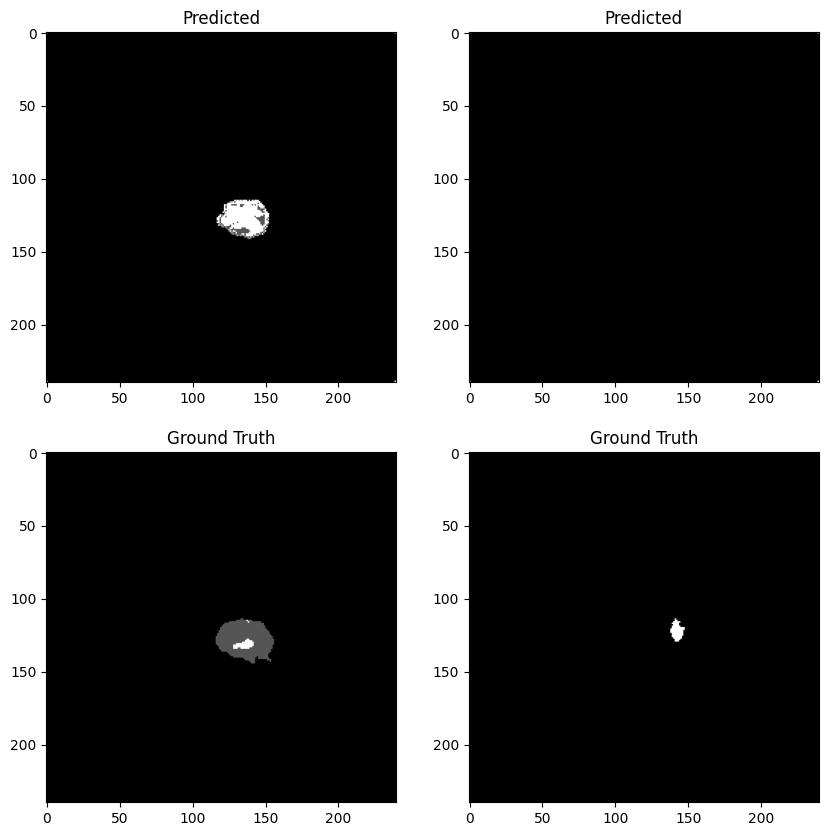

100%|██████████| 34/34 [01:04<00:00,  1.90s/it]


Average Validation Loss: 0.1227900149191127

Average Validation DSC: [0.99746238 0.39426378 0.22887191 0.37986095]
Average Validation ASSD: [  0.6540328  122.58826761 202.81414612  33.03489765]
Epoch 9/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


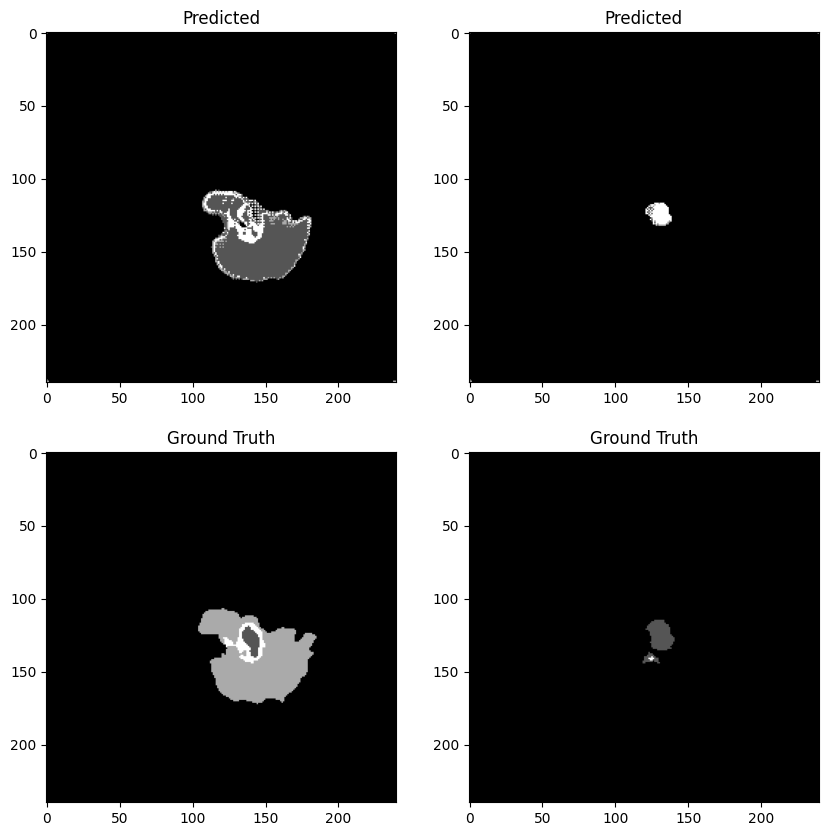

100%|██████████| 136/136 [05:11<00:00,  2.29s/it]



Average Training Loss: 0.12637188877252972

Average Training DSC: [0.99781705 0.36029862 0.05595976 0.39617997]
Average Training ASSD: [  0.53929482 142.48687032 270.69960801  28.55315954]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


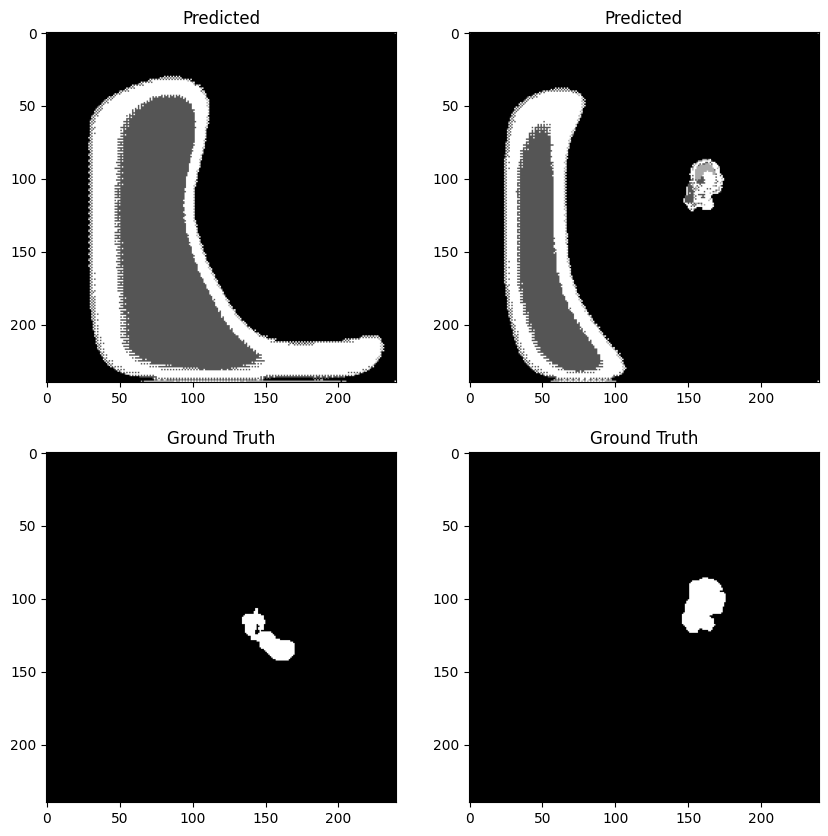

100%|██████████| 34/34 [01:06<00:00,  1.97s/it]


Average Validation Loss: 5.810729461557725

Average Validation DSC: [0.93787558 0.18554863 0.03932873 0.11528928]
Average Validation ASSD: [  3.89423335 183.22557657 277.94677664  51.05400477]
Epoch 10/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


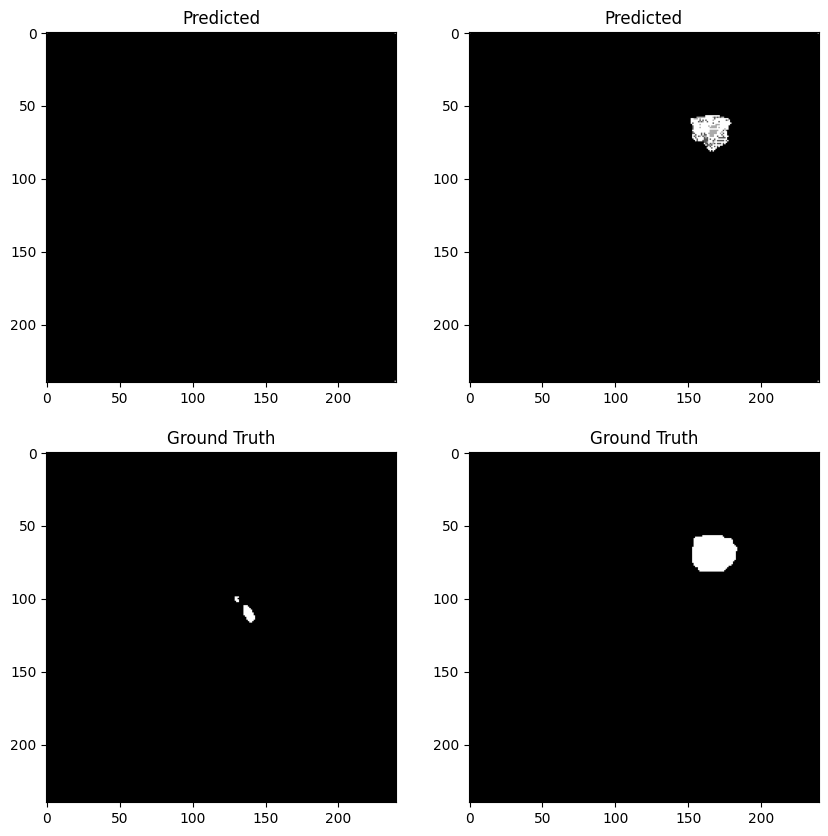

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.10357226699809818

Average Training DSC: [0.99787962 0.29398773 0.21116875 0.42521062]
Average Training ASSD: [  0.51217224 163.16817528 219.78403673  26.66756439]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


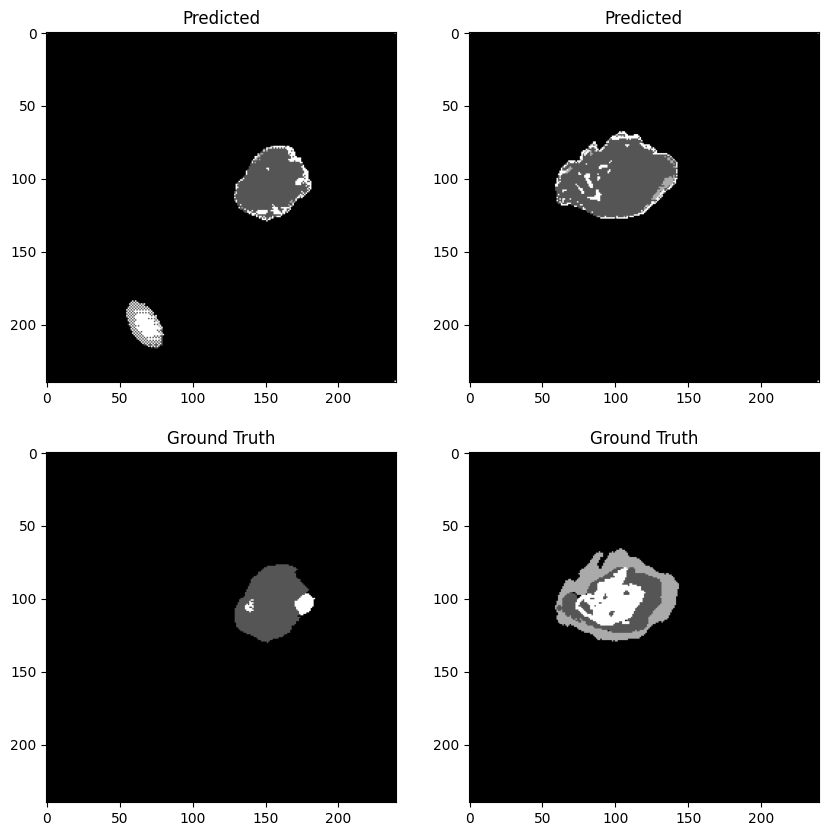

100%|██████████| 34/34 [01:05<00:00,  1.94s/it]


Average Validation Loss: 0.6933154937099008

Average Validation DSC: [0.987895   0.23926008 0.23458995 0.26396444]
Average Validation ASSD: [  2.39520434 179.14542575 200.82750597  35.31976197]
Epoch 11/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


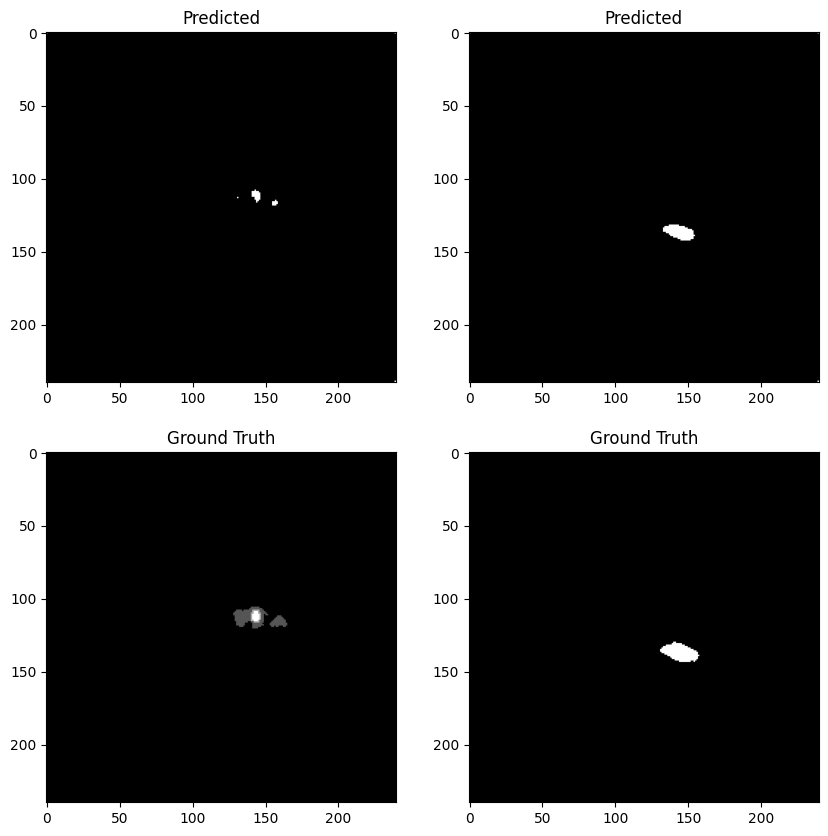

100%|██████████| 136/136 [05:09<00:00,  2.28s/it]



Average Training Loss: 0.08406641189118519

Average Training DSC: [0.99801932 0.35745927 0.3253442  0.43537049]
Average Training ASSD: [  0.48332461 144.83224154 183.54793903  26.88859204]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


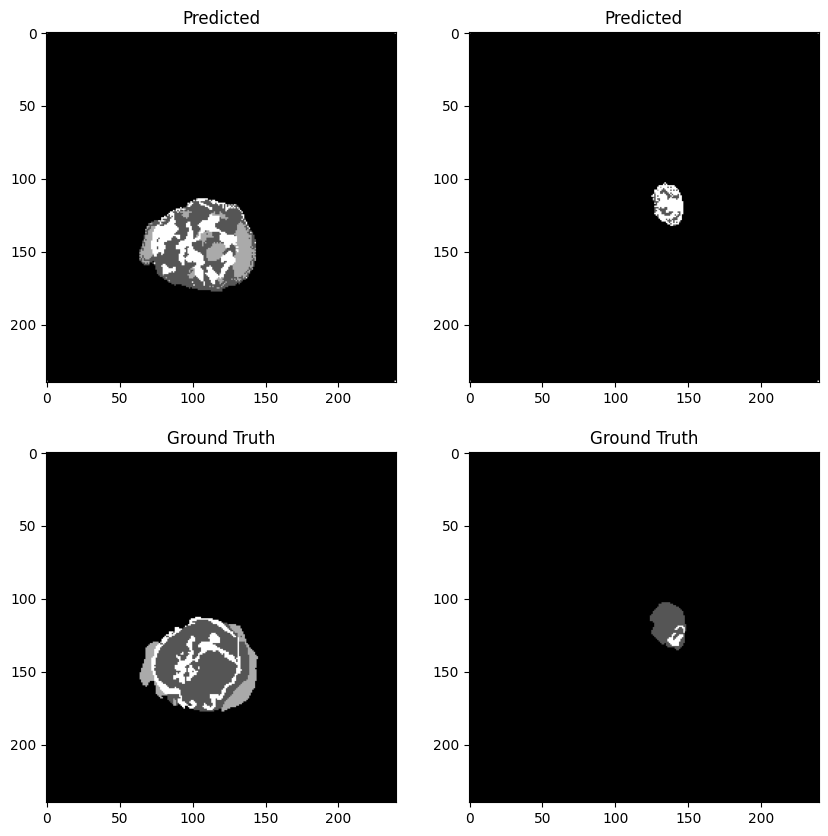

100%|██████████| 34/34 [01:04<00:00,  1.90s/it]


Average Validation Loss: 0.0785035125034697

Average Validation DSC: [0.99813821 0.38549812 0.31753972 0.46143603]
Average Validation ASSD: [  0.42580774 123.33201185 189.65993526  24.26574493]
Epoch 12/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


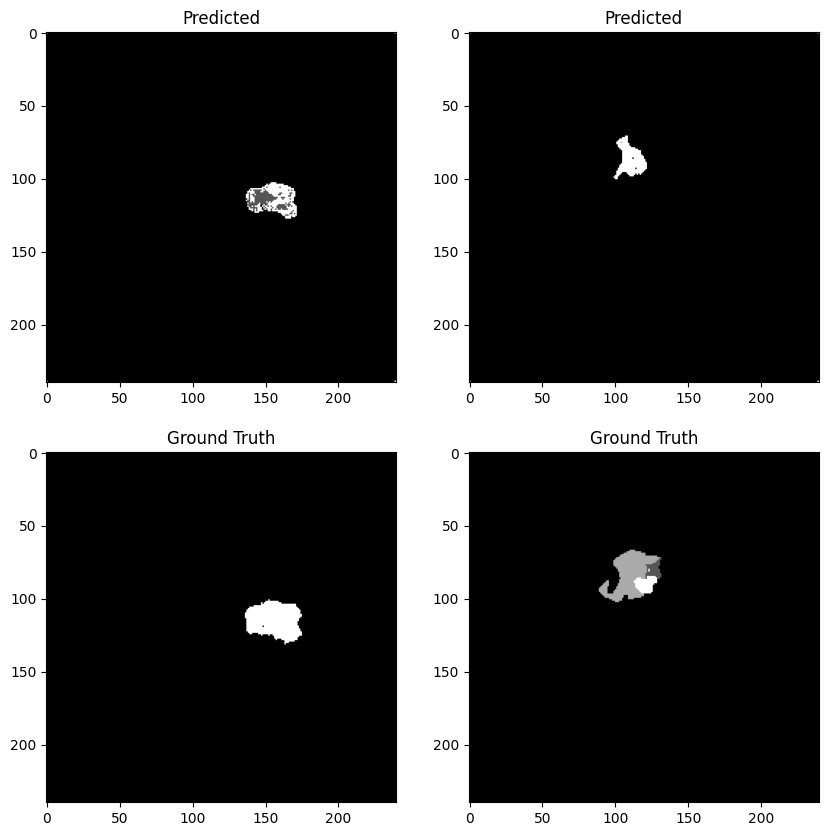

100%|██████████| 136/136 [05:15<00:00,  2.32s/it]



Average Training Loss: 0.07229108141516061

Average Training DSC: [0.9981101  0.38830751 0.36547655 0.45158518]
Average Training ASSD: [  0.44678058 139.21843509 173.72838399  25.56430302]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


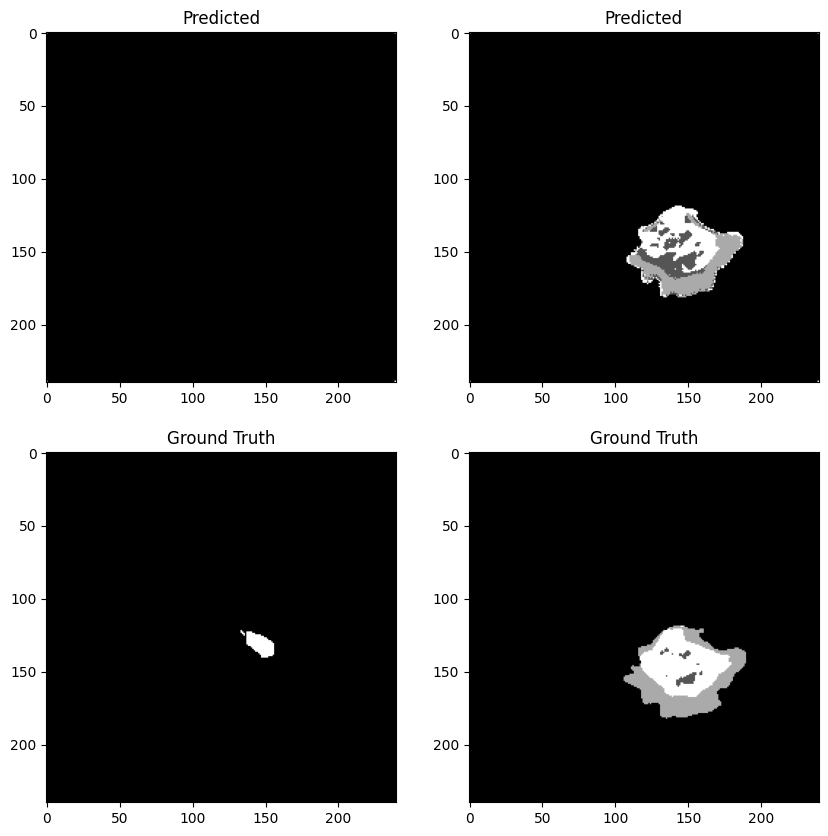

100%|██████████| 34/34 [01:07<00:00,  1.98s/it]


Average Validation Loss: 0.06178941983072197

Average Validation DSC: [0.99792568 0.46150643 0.31564359 0.42492472]
Average Validation ASSD: [  0.39919924 102.72775615 199.7495082   21.14914212]
Epoch 13/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


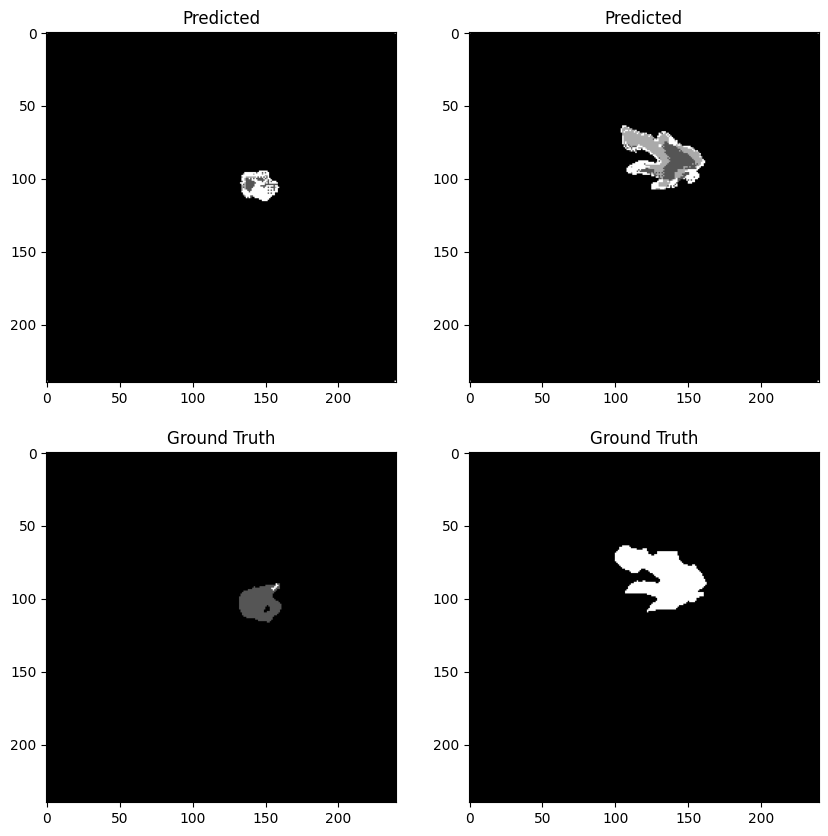

100%|██████████| 136/136 [05:17<00:00,  2.33s/it]



Average Training Loss: 0.06574803864692941

Average Training DSC: [0.99808021 0.39608747 0.41328589 0.46555348]
Average Training ASSD: [  0.44052453 135.38264411 161.33468418  24.87966391]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


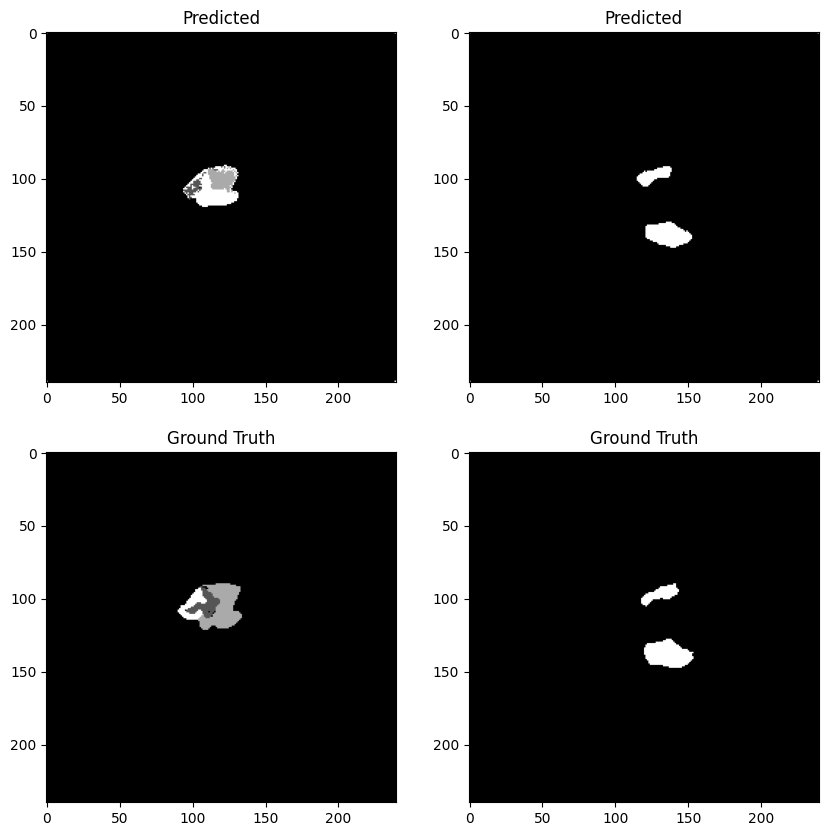

100%|██████████| 34/34 [01:20<00:00,  2.37s/it]


Average Validation Loss: 0.07286602017634056

Average Validation DSC: [0.99772141 0.38731848 0.46879205 0.45540084]
Average Validation ASSD: [  0.54318093 115.43011927 140.189067    27.13896063]
Epoch 14/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


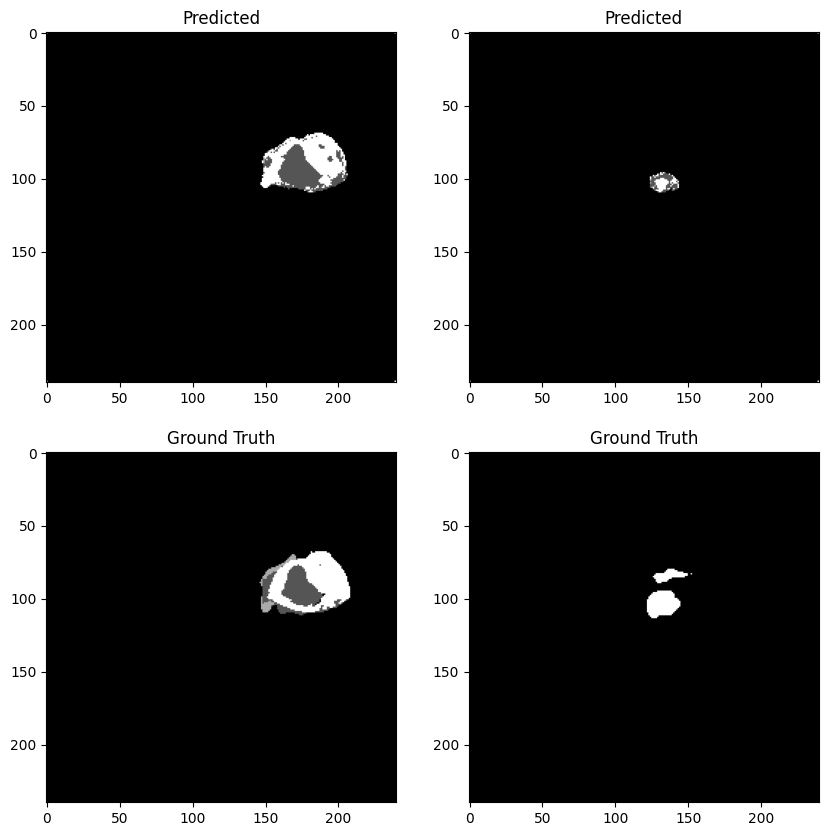

100%|██████████| 136/136 [18:58<00:00,  8.37s/it]



Average Training Loss: 0.061371849904603815

Average Training DSC: [0.99794939 0.40438866 0.49380533 0.45636444]
Average Training ASSD: [  0.47622643 133.74375301 136.91205725  25.46947746]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


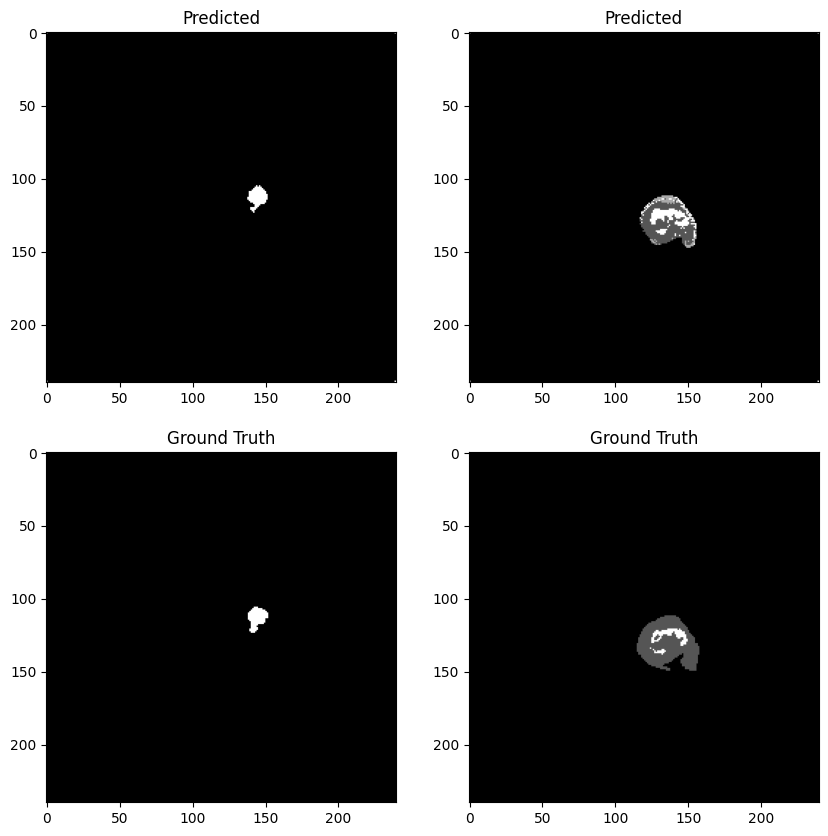

100%|██████████| 34/34 [04:44<00:00,  8.38s/it]


Average Validation Loss: 0.05759667900993543

Average Validation DSC: [0.99826386 0.42140017 0.53074424 0.50606122]
Average Validation ASSD: [  0.368707   113.09949087 124.95551087  19.84043514]
Epoch 15/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


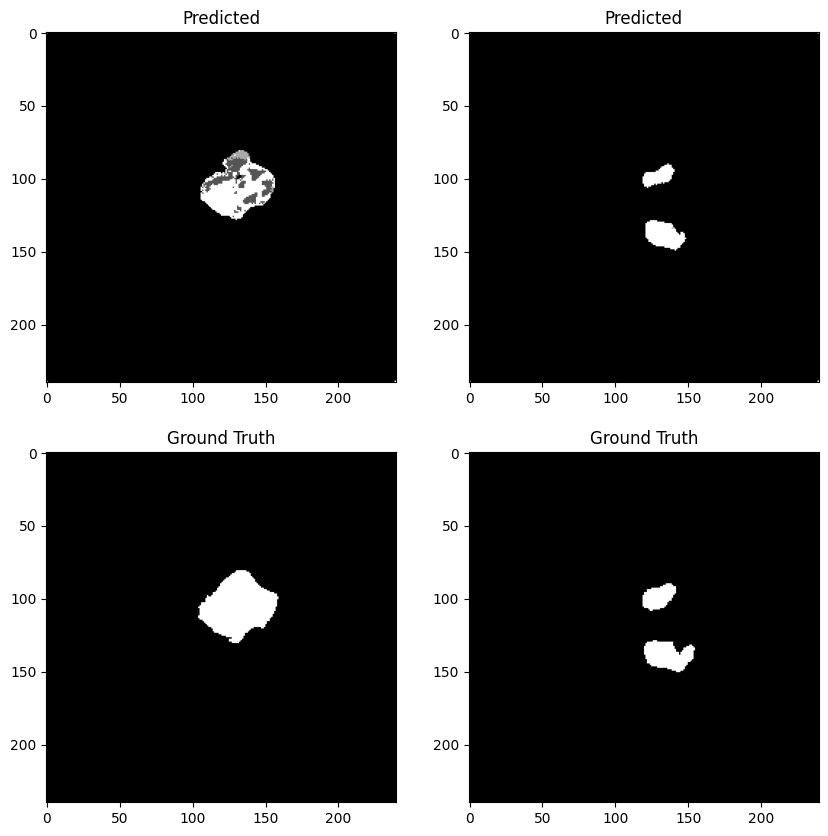

100%|██████████| 136/136 [20:28<00:00,  9.04s/it]



Average Training Loss: 0.05085830245276585

Average Training DSC: [0.99818433 0.42577599 0.55390377 0.48430013]
Average Training ASSD: [  0.39285648 131.41523854 122.70603131  23.34489376]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


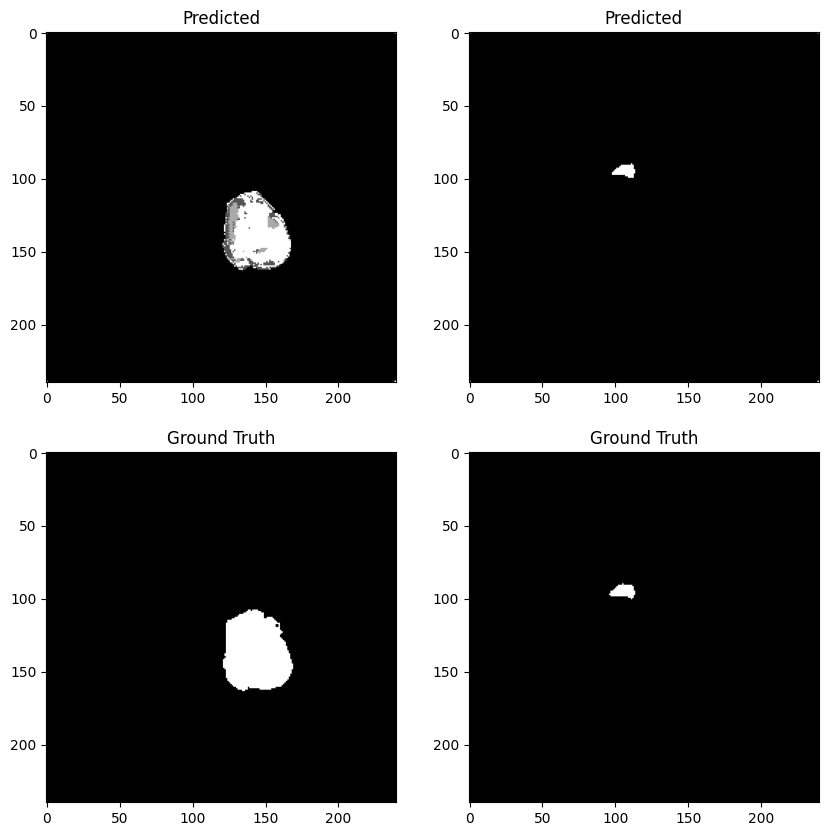

100%|██████████| 34/34 [04:59<00:00,  8.81s/it]


Average Validation Loss: 0.05117131243733799

Average Validation DSC: [0.99830999 0.41797867 0.607476   0.51160667]
Average Validation ASSD: [  0.3677228  117.16850004  95.05080656  22.04422424]
Epoch 16/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


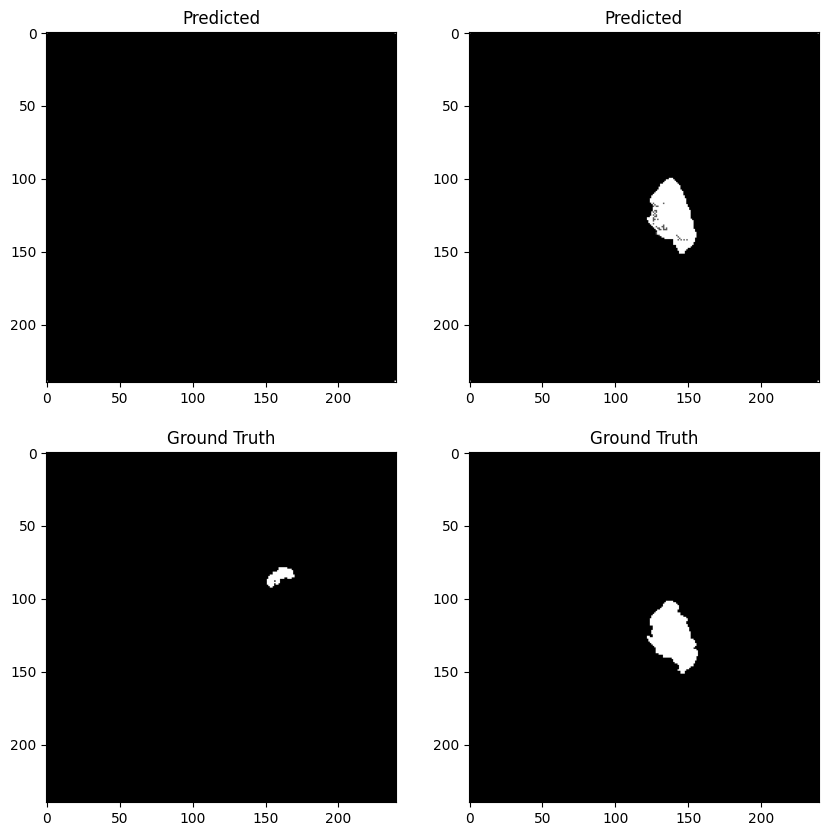

100%|██████████| 136/136 [20:41<00:00,  9.13s/it]



Average Training Loss: 0.04477074257481624

Average Training DSC: [0.99831162 0.3997954  0.61727263 0.51263046]
Average Training ASSD: [  0.35949135 142.69859963 103.89451545  21.77109823]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


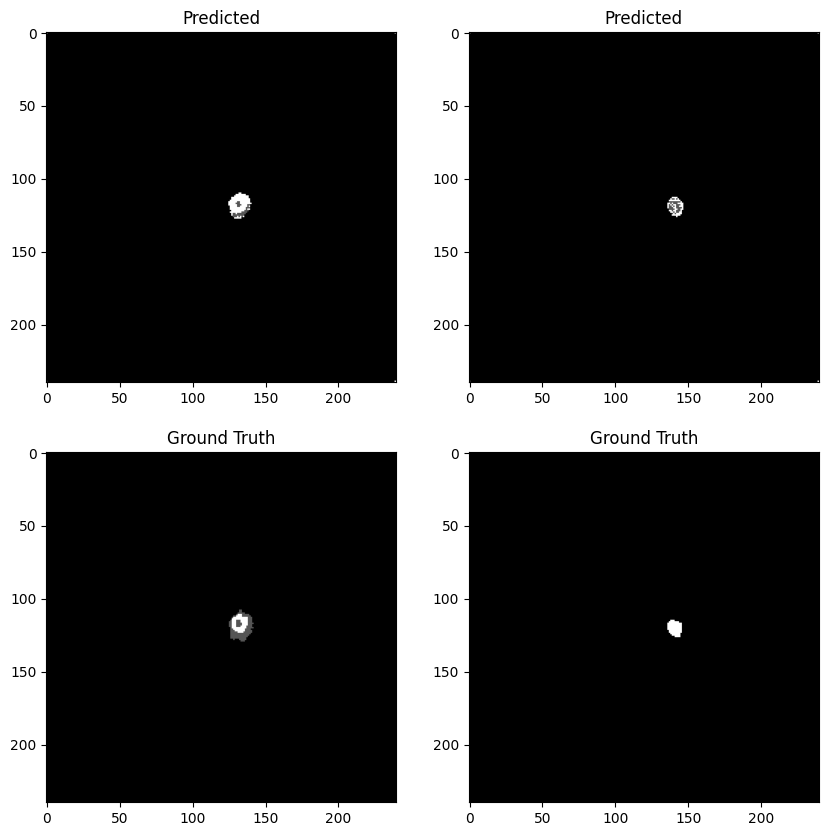

100%|██████████| 34/34 [04:44<00:00,  8.36s/it]


Average Validation Loss: 0.04437137767672539

Average Validation DSC: [0.99818597 0.29030094 0.73049008 0.50501483]
Average Validation ASSD: [  0.39208913 173.68388494  59.18076468  22.45445881]
Epoch 17/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


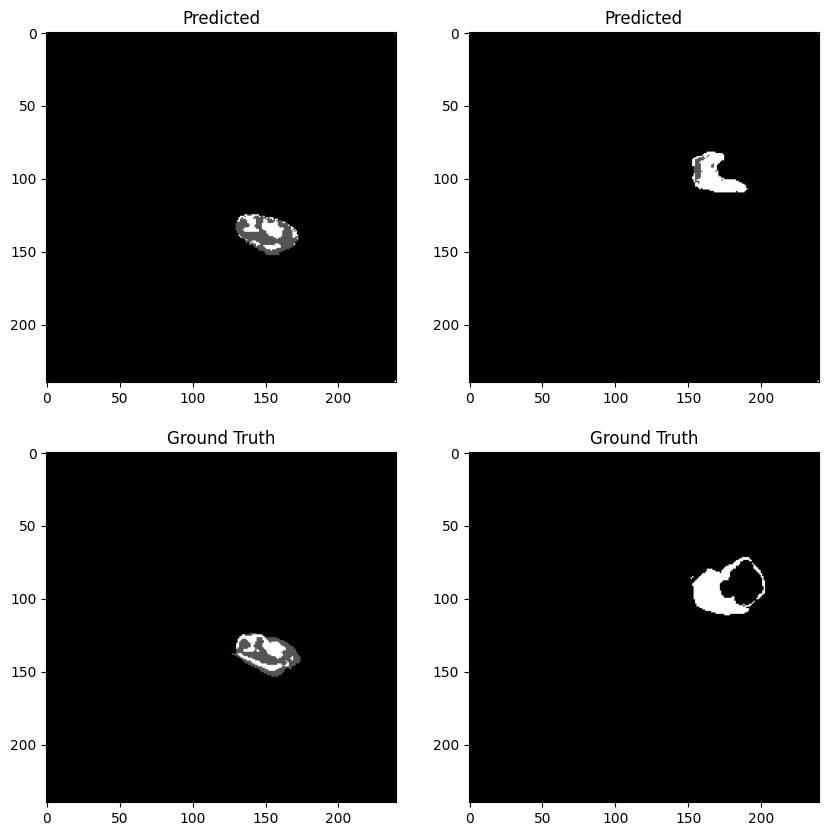

 57%|█████▋    | 77/136 [11:20<08:43,  8.87s/it]

In [ ]:
model = train_model(num_epochs = 100)